In [1]:
import pandas as pd
import os
import re
from datetime import datetime, timedelta
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


In [36]:
directory = './data/labels'
pattern = re.compile(r'screenshot(\d+)_(\d{2})_(\d{2})__(\d{2})_(\d{2})\.txt')
df = pd.DataFrame(columns=['Camera', 'Date', 'X_center', 'Y_center', 'Width', 'Height'])
numeric_cols = ['Camera', 'X_center', 'Y_center', 'Width', 'Height']


csv_file = 'positions.csv'
if os.path.exists(csv_file):
    df = pd.read_csv(csv_file)
else:
    for filename in os.listdir(directory):
        # print(filename)
        path = os.path.join(directory, filename)
        match = pattern.match(filename)
        assert match
        camera, day, month, hour, minute = map(int, match.groups())
        # Convert to datetime object
        data = {}
        timestamp = pd.Timestamp(year=2024, month=month, day=day, hour=hour, minute=minute)
        with open(path) as file:
            for item in file:
                _, x_center, y_center, width, height = item.strip().split()
                data['X_center'], data['Y_center'], data['Width'], data['Height'] = x_center, y_center, width, height
                data['Camera'] = camera
                data['Date'] = pd.to_datetime(timestamp)
                df = pd.concat([df, pd.DataFrame([data])], ignore_index=True)
    
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col])
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'] + pd.Timedelta(hours=1)
df.to_csv('positions.csv')


    
        

In [8]:
def get_heatmap(df, camera):
    df = df[df['Camera'] == camera]

    # Specify the dimensions of the heatmap
    heatmap_width, heatmap_height = 1920, 1000

    # Initialize a blank image for the heatmap
    heatmap_img = np.zeros((heatmap_height, heatmap_width), dtype=np.float32)

    # Function to apply intensity within the bounding box area
    def apply_bounded_gaussian_heatmap(cx, cy, w, h, heatmap):
        # Calculate the bounding box in pixel coordinates
        left = int(max(0, cx - w * heatmap_width / 2))
        right = int(min(heatmap_width, cx + w * heatmap_width / 2))
        top = int(max(0, cy - h * heatmap_height / 2))
        bottom = int(min(heatmap_height, cy + h * heatmap_height / 2))

        sigma_x = w * heatmap_width / 6
        sigma_y = h * heatmap_height / 6

        # Apply intensity only within the bounding box, using a Gaussian distribution
        for y in range(top, bottom):
            for x in range(left, right):
                dx = cx - x
                dy = cy - y
                value = np.exp(-(dx ** 2 / (2 * sigma_x ** 2) + dy ** 2 / (2 * sigma_y ** 2)))
                heatmap[y, x] += value

    # Populate the heatmap with bounded Gaussian distribution
    for index, row in df.iterrows():
        cx, cy, w, h = row['X_center'] * heatmap_width, row['Y_center'] * heatmap_height, row['Width'], row['Height']
        apply_bounded_gaussian_heatmap(cx, cy, w, h, heatmap_img)

    # Normalize the heatmap
    cv2.normalize(heatmap_img, heatmap_img, 0, 255, norm_type=cv2.NORM_MINMAX)
    zero_mask = (heatmap_img < 20)
    # Apply a colormap to create a color heatmap
    heatmap_color = cv2.applyColorMap(np.uint8(heatmap_img), cv2.COLORMAP_JET)
    heatmap_color[zero_mask] = (0,0,0)
    # plt.figure()
    # plt.imshow(heatmap_color[..., ::-1])  # change channels order since the YOLO work on BGR images
    # plt.show()
    return heatmap_color

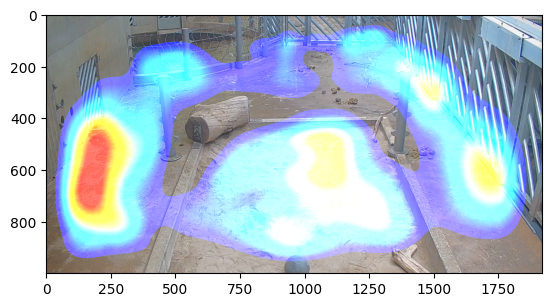

In [9]:
# Optionally, load an actual image to overlay the heatmap on
original_img = cv2.imread('data/images/screenshot1_01_02__11_15.png')
heatmap_color = get_heatmap(df, 1)
overlayed_img = cv2.addWeighted(original_img, 1, heatmap_color, 1, 0)
plt.figure()
plt.imshow(overlayed_img[..., ::-1])  # change channels order since the YOLO work on BGR images
plt.show()


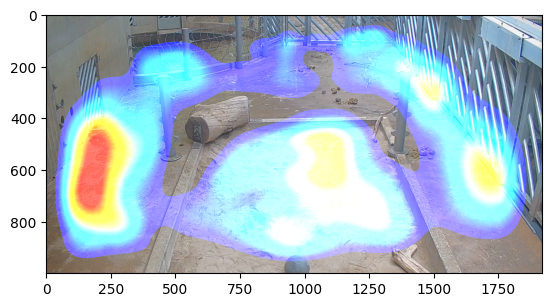

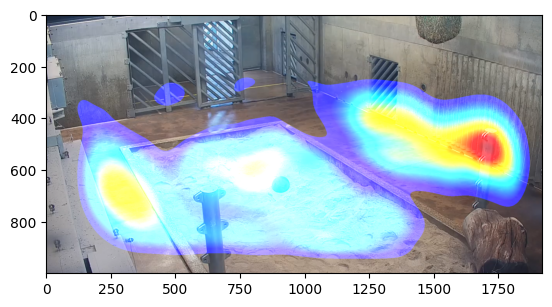

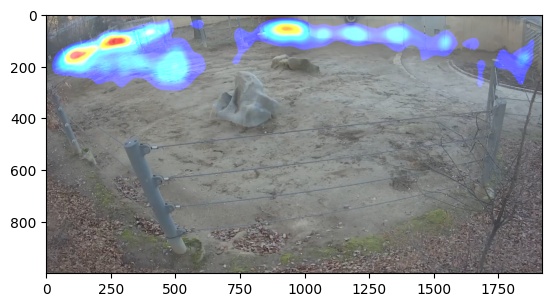

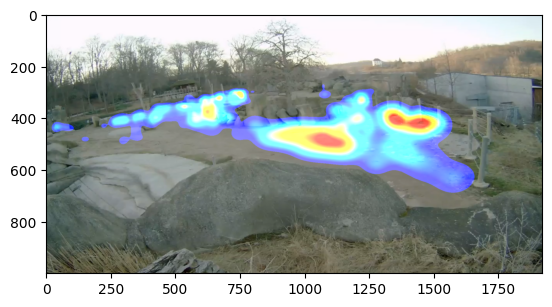

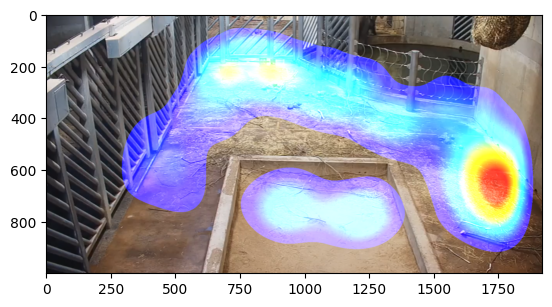

In [71]:
camera_to_path = {
    1: 'data/images/screenshot1_01_02__11_15.png',
    2: 'data/images/screenshot2_04_02__13_15.png',
    4: 'data/images/screenshot4_05_02__14_30.png',
    6: 'data/images/screenshot6_28_01__15_15.png',
    7: 'data/images/screenshot7_29_01__15_15.png'}
for key in camera_to_path.keys():
    heatmap_color = get_heatmap(df, key)
    original_img = cv2.imread(camera_to_path[key])
    overlayed_img = cv2.addWeighted(original_img, 1, heatmap_color, 1, 0)
    plt.figure()
    plt.imshow(overlayed_img[..., ::-1])  # change channels order since the YOLO work on BGR images
    plt.show()


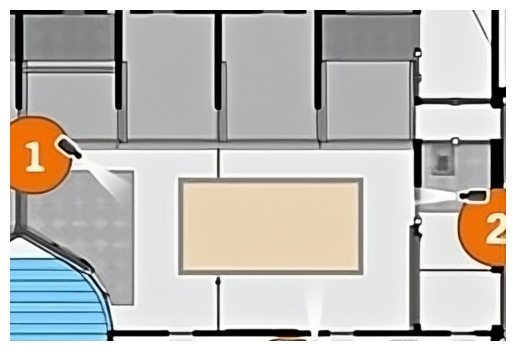

In [12]:
def show(img):
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # change channels order since the YOLO work on BGR images
    plt.axis('off')
    plt.show()
background = cv2.imread('back.jpeg')
show(background)

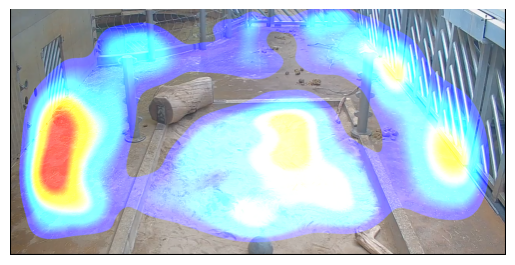

In [6]:
img = cv2.imread('output.png')
show(img)

In [7]:
image_pts = [(85, 56), (344, 13), (340, 88), (155, 96)]
air_pts = [(178, 551), (30, 243), (291, 292), (292, 460)]
H, mask = H, mask = cv2.findHomography(np.array(image_pts), np.array(air_pts))
print(H)

[[ 1.26774648e-01  5.78395911e+00 -8.68939492e+01]
 [-1.51578275e+00  2.69704714e+00  7.44822439e+02]
 [-8.45288316e-05  7.12906574e-03  1.00000000e+00]]


572 856


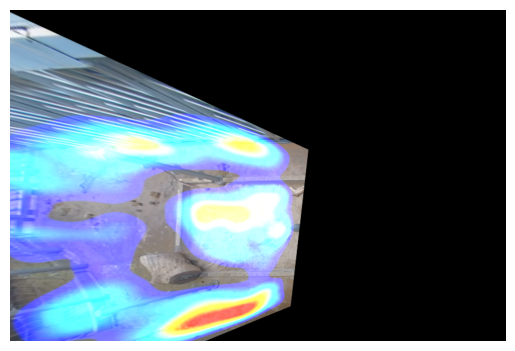

In [25]:
height, width = background.shape[:2]
print(height, width)
dst = cv2.warpPerspective(img, H, (width, height))
show(dst)


In [60]:
def get_heatmap_new(df, camera):
    df = df[df['Camera'] == camera]

    # Specify the dimensions of the heatmap
    heatmap_width, heatmap_height = 856, 572

    # Initialize a blank image for the heatmap
    heatmap_img = np.zeros((heatmap_height, heatmap_width), dtype=np.float32)

    # Function to apply intensity within the bounding box area
    def apply_bounded_gaussian_heatmap(cx, cy, w, h, heatmap):
        # Calculate the bounding box in pixel coordinates
        left = int(max(0, cx - w * heatmap_width / 2))
        right = int(min(heatmap_width, cx + w * heatmap_width / 2))
        top = int(max(0, cy - h * heatmap_height / 2))
        bottom = int(min(heatmap_height, cy + h * heatmap_height / 2))

        sigma_x = w * heatmap_width / 6
        sigma_y = h * heatmap_height / 6

        # Apply intensity only within the bounding box, using a Gaussian distribution
        for y in range(top, bottom):
            for x in range(left, right):
                dx = cx - x
                dy = cy - y
                value = np.exp(-(dx ** 2 / (2 * sigma_x ** 2) + dy ** 2 / (2 * sigma_y ** 2)))
                heatmap[y, x] += value

    # Populate the heatmap with bounded Gaussian distribution
    for index, row in df.iterrows():
        cx, cy, w, h = row['X_center_prime'] * heatmap_width, row['Y_center_prime'] * heatmap_height, row['Width_prime'], row['Height_prime']
        apply_bounded_gaussian_heatmap(cx, cy, w, h, heatmap_img)

    # Normalize the heatmap
    cv2.normalize(heatmap_img, heatmap_img, 0, 255, norm_type=cv2.NORM_MINMAX)
    zero_mask = (heatmap_img < 20)
    # Apply a colormap to create a color heatmap
    heatmap_color = cv2.applyColorMap(np.uint8(heatmap_img), cv2.COLORMAP_JET)
    heatmap_color[zero_mask] = (0,0,0)
    # plt.figure()
    # plt.imshow(heatmap_color[..., ::-1])  # change channels order since the YOLO work on BGR images
    # plt.show()
    return heatmap_color

In [45]:
def transform_row(M, x, y, width, height):
    x, y = x*856, y*572
    width, height = width*856, height*572
    def transform_point(M, x, y):
        x_prime = (M[0, 0] * x + M[0, 1] * y + M[0, 2]) / (M[2, 0] * x + M[2, 1] * y + M[2, 2])
        y_prime = (M[1, 0] * x + M[1, 1] * y + M[1, 2]) / (M[2, 0] * x + M[2, 1] * y + M[2, 2])
        return x_prime, y_prime
    x_prime, y_prime = transform_point(M, x, y)
    
    left, right = x - width/2, x + width/2
    left_prime = transform_point(M, left, y)
    right_prime = transform_point(M, right, y)
    width_prime = np.linalg.norm(np.array(left_prime)-np.array(right_prime))
    up, down = y - height/2, y + height/2
    up_prime = transform_point(M, x, up)
    down_prime = transform_point(M, x, down)
    height_prime = np.linalg.norm(np.array(up_prime)-np.array(down_prime))
    return x_prime/856, y_prime/572, width_prime/856, height_prime/572


In [57]:
df_new = pd.DataFrame(columns=['Camera', 'X_center_prime', 'Y_center_prime', 'Width_prime', 'Height_prime'])
sub = df[df['Camera'] == 1]
sub.reset_index(inplace=True)
for index, row in sub.iterrows():
    data = {}
    data['Camera'] = 1
    data['X_center_prime'], data['Y_center_prime'], data['Width_prime'], data['Height_prime'] = transform_row(H, row['X_center'], row['Y_center'], row['Width'], row['Height'])
    # print(data)
    df_new = pd.concat([df_new, pd.DataFrame([data])], ignore_index=True)
df_new

/var/folders/tl/h1jkjn_97773_b51y3fb7cfw0000gn/T/ipykernel_13218/1688655474.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_new = pd.concat([df_new, pd.DataFrame([data])], ignore_index=True)


Camera  X_center_prime  Y_center_prime  Width_prime  Height_prime
0        1        0.493334        0.670918     0.144869      0.667986
1        1        0.445841        0.704636     0.147584      0.861098
2        1        0.688595        0.289030     0.124130      0.643649
3        1        0.715382        0.275440     0.051583      0.376675
4        1        0.606617        0.804727     0.070464      0.423314
..     ...             ...             ...          ...           ...
388      1        0.626198        0.785699     0.099645      0.315112
389      1        0.670177        0.585573     0.141606      0.257480
390      1        0.459536        0.639714     0.135165      0.493571
391      1        0.461648        0.221900     0.097499      0.576500
392      1        0.602028        0.799733     0.094709      0.385801

[393 rows x 5 columns]

In [53]:
# import numpy as np

# sub = df[df['Camera'] == 1]
# def transform_row(M, x, y, width, height):
#     x, y = x*856, y*572
#     width, height = width*856, height*572
#     def transform_point(M, x, y):
#         x_prime = (M[0, 0] * x + M[0, 1] * y + M[0, 2]) / (M[2, 0] * x + M[2, 1] * y + M[2, 2])
#         y_prime = (M[1, 0] * x + M[1, 1] * y + M[1, 2]) / (M[2, 0] * x + M[2, 1] * y + M[2, 2])
#         return x_prime, y_prime
#     x_prime, y_prime = transform_point(M, x, y)
    
#     left, right = x - width/2, x + width/2
#     left_prime = transform_point(M, left, y)
#     right_prime = transform_point(M, right, y)
#     width_prime = np.linalg.norm(np.array(left_prime)-np.array(right_prime))
#     up, down = y - height/2, y + height/2
#     up_prime = transform_point(M, x, up)
#     down_prime = transform_point(M, x, down)
#     height_prime = np.linalg.norm(np.array(up_prime)-np.array(down_prime))
#     return x_prime/856, y_prime/572, width_prime/856, height_prime/572

    
# a,b,c, d= transform_row(H, 0.279167, 	0.2965,	0.212500, 0.439)
    

# # sub['X_center_prime'], sub['Y_center_prime'], sub['Width_prime'], sub['Height_prime'] = transform_row(H, sub['X_center'], sub['Y_center'], sub['Width'], sub['Height'])

# d

0.6679855956853896

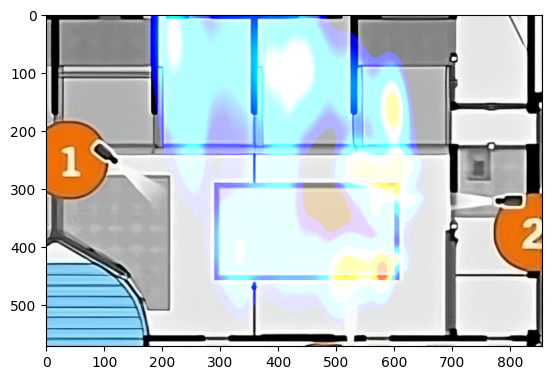

In [61]:
# Optionally, load an actual image to overlay the heatmap on
original_img = cv2.imread('back.jpeg')
heatmap_color = get_heatmap_new(df_new, 1)
overlayed_img = cv2.addWeighted(original_img, 1, heatmap_color, 1, 0)
plt.figure()
plt.imshow(overlayed_img[..., ::-1])  # change channels order since the YOLO work on BGR images
plt.show()


In [63]:
sub

index  Unnamed: 0.6  Unnamed: 0.5  Unnamed: 0.4  Unnamed: 0.3  \
0       21            21            21            21            21   
1       22            22            22            22            22   
2       23            23            23            23            23   
3       26            26            26            26            26   
4       27            27            27            27            27   
..     ...           ...           ...           ...           ...   
388   2792          2792          2792          2792          2792   
389   2796          2796          2796          2796          2796   
390   2797          2797          2797          2797          2797   
391   2820          2820          2820          2820          2820   
392   2821          2821          2821          2821          2821   

     Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  Camera                Date  \
0              21            21          21       1 2024-02-05 22:15:00   
1              22            22          22       1 2024-02-05 22:15:00   
2              23            23          23       1 2024-02-05 23:15:00   
3              26            26          26       1 2024-02-06 13:45:00   
4              27            27          27       1 2024-02-06 13:45:00   
..            ...           ...         ...     ...                 ...   
388          2792          2792        2792       1 2024-02-07 01:15:00   
389          2796          2796        2796       1 2024-01-27 05:15:00   
390          2797          2797        2797       1 2024-01-27 05:15:00   
391          2820          2820        2820       1 2024-02-06 04:00:00   
392          2821          2821        2821       1 2024-02-06 04:00:00   

     X_center  Y_center     Width  Height  
0    0.279167    0.2965  0.212500   0.439  
1    0.249740    0.2480  0.197396   0.444  
2    0.858854    0.6040  0.279167   0.780  
3    0.936458    0.6855  0.127083   0.593  
4    0.093490    0.4975  0.143229   0.519  
..        ...       ...       ...     ...  
388  0.109635    0.5405  0.214062   0.455  
389  0.407813    0.6185  0.330208   0.481  
390  0.308333    0.2570  0.183333   0.304  
391  0.663021    0.2305  0.121875   0.285  
392  0.103125    0.4865  0.189583   0.471  

[393 rows x 14 columns]